## Logistic Regression to Predict High or Low Traffic Accident Severity

First pass accuracy was 69.44% and below are original classification and confusion matrix.  Updates are adding Distance, Precipitation and Visibility as binary columns and identifying feature reduction.

In [30]:
# accuracy_score first pass (y_test, y_pred)

0.6944069801888199

In [33]:
# classification report first pass
# print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.94      0.81    367866
           1       0.59      0.18      0.28    175615

    accuracy                           0.69    543481
   macro avg       0.65      0.56      0.54    543481
weighted avg       0.67      0.69      0.64    543481



In [32]:
# confusion matrix first pass
# print(confusion_matrix(y_test, y_pred))

[[345447  22419]
 [143665  31950]]


False positives in the lower left corner appear to drive the inaccuracy

The high recall for 0 is an indication most low-severity traffic accidents were predicted correctly.

In [37]:
# 5-fold cross-validation scores
cv_scores = cross_val_score(pipeline, X, y, cv=5)

# CV Scores first pass
print(cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.69358818 0.6947529  0.69213827 0.68903789 0.69176419]
Average 5-Fold CV Score: 0.6922562855975413


I don't believe there is overfitting due to the low variation in cross-validation.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
data = pd.read_csv('C:/data/Accidents.csv')

In [5]:
# Reduce traffic Severity from four categories down to two for Logistic Regression
data['Severity01'] = data['Severity'].apply(lambda x: 1 if x >= 3 else 0)
data['SeverityLoHi'] = data['Severity'].apply(lambda x: "High" if x >= 3 else "Low")

In [6]:
# These features with a high percentage of single values made binary
data['DistanceZero'] = data['Distance(mi)'].apply(lambda x: 1 if x == 0 else 0)
data['PrecipitationZero'] = data['Precipitation(in)'].apply(lambda x: 1 if x == 0 else 0)
data['VisibilityTen'] = data['Distance(mi)'].apply(lambda x: 1 if x == 10 else 0)

In [7]:
# Convert Civil Twilight from Day Night to 0 1
data['DayNight01'] = data['Civil_Twilight'].apply(lambda x: 1 if x == 'Night' else 0)

Text(0.5, 1.0, 'Low vs High Accident Traffic Severity Counts')

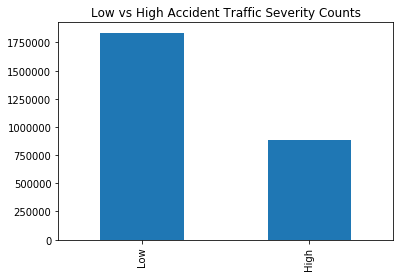

In [18]:
# Twice as many Low Severity Accidents vs. High Severity
data.SeverityLoHi.value_counts().plot(kind='bar')
plt.title('Low vs High Accident Traffic Severity Counts')


In [8]:
subset = data.drop(['Weather_Timestamp', 'Weather_Condition', 'ID', 'Source', 'Severity', 'SeverityLoHi', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'Description', 'Wind_Direction', 'Street', 'Side', 'City', 'County', 'State', 'Zipcode', 'Zip2', 'Country', 'Timezone', 'Airport_Code', 'Duration', 'Month', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'], axis = 1)

In [9]:
subset = pd.get_dummies(data = subset, columns = ['Weather_Group', 'weekday', 'hour'] )

In [21]:
subset.columns

Index(['Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Duration(m)',
       'Severity01', 'DistanceZero', 'PrecipitationZero', 'VisibilityTen',
       'DayNight01', 'Weather_Group_Clear', 'Weather_Group_Cloudy',
       'Weather_Group_Heavy Precip', 'Weather_Group_Light Precip',
       'Weather_Group_Obscured', 'Weather_Group_Windy', 'weekday_Fri',
       'weekday_Mon', 'weekday_Sat', 'weekday_Sun', 'weekday_Thu',
       'weekday_Tue', 'weekday_Wed', 'hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22'

In [22]:
subset.shape

(2717404, 64)

## Feature Reduction

In [25]:
# In EDA, only correlation over 50% was between Temperature and Wind Chill.  Remove Wind Chill.
old_corr = subset[['Temperature(F)', 'Wind_Chill(F)']]
corr = old_corr.corr(method = 'pearson')
print(corr)

                Temperature(F)  Wind_Chill(F)
Temperature(F)        1.000000       0.833849
Wind_Chill(F)         0.833849       1.000000


In [10]:
subset = subset.drop(['Wind_Chill(F)'], axis = 1)

In [11]:
# Separate X, y
y = subset.Severity01
X = subset.drop(['Severity01'], axis=1)

In [30]:
X.shape

(2717404, 62)

In [12]:
# Run a tree-based estimator

dt = DecisionTreeClassifier(random_state = 7, criterion = 'entropy', max_depth =10)
dt.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=7, splitter='best')

In [13]:
# Feature importance rank
fi_col = []
fi = []
for i, column in enumerate(subset.drop(['Severity01'], axis=1)):
    fi_col.append(column)
    fi.append(dt.feature_importances_[i])    # attribute of Decision Tree Classifier

In [15]:
# View Feature importance rank
fi_df = zip(fi_col, fi)
fi_df = pd.DataFrame(fi_df, columns = ['Feature', 'Importance'])
fi_df = fi_df.sort_values('Importance', ascending = False).reset_index()
fi_df[fi_df.Importance > 0]

,index,Feature,Importance
0,20,Duration(m),0.380498
1,18,Traffic_Signal,0.309682
2,0,Distance(mi),0.104732
3,16,Stop,0.032127
4,11,Junction,0.031207
5,33,weekday_Sat,0.029693
6,9,Crossing,0.028131
7,34,weekday_Sun,0.026977
8,24,DayNight01,0.020618
9,3,Pressure(in),0.009415


An interesting ranking.  Seven fields had zero impact on the dependent variable.  Traffic signals, stop signs, intersections and crosswalks are far more indicative of traffic severity than weather.  There are no weather indicators until the 10th - 12th position, unexpectedly lead by Pressure.  One of the created fields, DayNight, made the top ten.  I am surprised to see Heavy Precipitation ranking so low, maybe due to causing slower travel speeds.  

There is also a large spread between weekend days and weekdays.  I can exclude time of day from our predictive model by limiting to the first twelve features in the ranking.

In [16]:
columns_to_keep = fi_df['Feature'][0:12]

In [17]:
# Split X, y kept columns
X = subset[columns_to_keep].values
y = subset['Severity01'].astype(int)

In [18]:
# Create training, test, validate sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=7)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, random_state=7)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(1956530, 12)
(543481, 12)
(217393, 12)
(1956530,)
(543481,)
(217393,)


In [19]:
steps = [('scaler', StandardScaler()), ('logreg', LogisticRegression(random_state = 7, solver='saga'))]

In [20]:
pipeline = Pipeline(steps)

In [21]:
logreg_scaled = pipeline.fit(X_train, y_train)

In [22]:
# Predict class labels for samples in X
y_pred = logreg_scaled.predict(X_test)

In [23]:
# Probability estimates
pred_proba = logreg_scaled.predict_proba(X_test)

# Evaluate the Linear Regression Model

In [24]:
# Accuracy on training
print("The training accuracy is ", logreg_scaled.score(X_train, y_train))

# Accuracy on testing
print("The testing accuracy is ", logreg_scaled.score(X_test, y_test))

The training accuracy is  0.6912707701900814
The testing accuracy is  0.6924124302413516


Narrowing the feature selection has a lower accuracy score then the original run.  I will re-evaluate with all the features with an Important score above 0.

In [25]:
more_columns_to_keep = fi_df['Feature'][0:55]
X2 = subset[more_columns_to_keep].values
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size = 0.2, random_state=7)
X2_train, X2_valid, y_train, y_valid = train_test_split(X2_train, y_train, test_size = 0.1, random_state=7)
steps2 = [('scaler2', StandardScaler()), ('logreg2', LogisticRegression(random_state = 7))]
pipeline2 = Pipeline(steps2)
logreg2_scaled = pipeline2.fit(X2_train, y_train)
print("The 2nd testing accuracy is ", logreg2_scaled.score(X2_test, y_test))

The 2nd testing accuracy is  0.6938862628132354


The original logistic regression, the details of which I did not keep for reproduction, had the highest accuracy score of 69.44.  It used all of the fields from EDA and did not include the new binary columns for Distance, Precipitation and Visibility.  Selecting the top 12 features by importance of a decision tree classifier yielded lower accuracy of 69.24.  The third pass using all features greater than zero importance yielded accuracy of 69.39.

In [68]:
# 5-fold cross-validation scores
cv_scores = cross_val_score(pipeline2, X2, y, cv=5)

In [69]:
# CV Scores first pass
print(cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.68999284 0.69549809 0.69052276 0.68822093 0.69239346]
Average 5-Fold CV Score: 0.6913256185196776


In [74]:
y_pred2 = logreg2_scaled.predict(X2_test)
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.71      0.94      0.81    367866
           1       0.58      0.19      0.28    175615

    accuracy                           0.69    543481
   macro avg       0.64      0.56      0.54    543481
weighted avg       0.67      0.69      0.64    543481



The high recall for 0 is an indication most low-severity traffic accidents were predicted correctly.

In [78]:
print(confusion_matrix(y_test, y_pred2))

[[344028  23838]
 [142529  33086]]


In [79]:
# confusion matrix percentages
cm = confusion_matrix(y_test, y_pred2)
cmpct = cm / cm.sum(axis=1).reshape(-1,1)
print(cmpct)

[[0.93519923 0.06480077]
 [0.81159924 0.18840076]]


False positives in the lower left corner appear to drive the inaccuracy.  They are actual high severity traffic (1) but predicted incorrectly as low severity (0).  High severity accident traffic was only correctly predicted 18.8% of the time.

In [83]:
# Log Loss on testing
from sklearn.metrics import log_loss
pred_proba2 = logreg2_scaled.predict_proba(X2_test)
print("The Log Loss on Test dataset is ", log_loss(y_test, pred_proba2))

The Log Loss on Test dataset is  0.5752759625997073


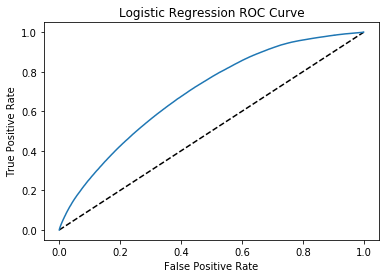

In [72]:
# Plotting the ROC curve
y_pred_prob = pipeline2.predict_proba(X2_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label = 'Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel("True Positive Rate")
plt.title('Logistic Regression ROC Curve')
plt.show()

In [84]:
roc_auc_score(y_test, y_pred_prob)

0.694535048057978

In [ ]:
# Hyperparameter C
from sklearn.linear_model import LogisticRegressionCV
C_List = np.geomspace(1e-5, 1e5, num=20)
kf = KFold(n_splits = 3, random_state = 0, shuffle = True)
Logreg3 = LogisticRegressionCV(cv=kf, random_state=15, Cs = C_List)
Logreg3.fit(X2_train, y_train)
print("The CA is ", Logreg3.score(X2_test, y_test))


C:\Users\ggibs\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ggibs\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg